In [25]:
from google.colab import drive
drive.mount('/content/drive')
# change the directory to your data
%cd /content/drive/My Drive/Colab Notebooks/Sudoku Solver/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Sudoku Solver


In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import imutils
from google.colab.patches import cv2_imshow # to avoid 

In [27]:
# DataFlair Sudoku solver
def isinRange(board):
  N = 9
  for i in range(0, N):
    for j in range(0, N):
      # lies in the range
      if ((board[i][j] <= 0) or
          (board[i][j] > 9)):
        return False
  return True
 
# of sudoku puzzle is valid or not
def check_grid(board):
  N = 9
  if (isinRange(board) == False):
    return False
 
  # Stores unique value
  unique = [False] * (N + 1)
  # Traverse each row of
  for i in range(0, N):
    for m in range(0, N + 1):
      unique[m] = False
    for j in range(0, N):
      Z = board[i][j]
      if (unique[Z] == True):
        return False
      unique[Z] = True
  for i in range(0, N):
    for m in range(0, N + 1):
      unique[m] = False
    for j in range(0, N):
      Z = board[j][i]
      if (unique[Z] == True):
        return False
      unique[Z] = True
  # size 3 * 3 in board[][] array
  for i in range(0, N - 2, 3):
    for j in range(0, N - 2, 3):
      for m in range(0, N + 1):
        unique[m] = False
      for k in range(0, 3):
        for l in range(0, 3):
          X = i + k
          Y = j + l
          Z = board[X][Y]
          if (unique[Z] == True):
            return False
          unique[Z] = True
  return True

# checkes where is an empty or unsolved block
def find_empty(board):
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                return (i, j)  # row, col
    return None

# validates if the board can be solved or not
def valid(board, num, pos):
    # Check row
    for i in range(len(board[0])):
        if board[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(board)):
        if board[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if board[i][j] == num and (i,j) != pos:
                return False

    return True

# loop through each empty and nonempty element
def solve(board):
    find = find_empty(board)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(board, i, (row, col)):
            board[row][col] = i

            if solve(board):
                return True
            board[row][col] = 0
    return False

def get_board(bo):
    """Takes a 9x9 matrix unsolved sudoku board and returns a fully solved board."""
    if solve(bo):
        return bo
    else:
        raise ValueError

def get_perspective(img, location, height = 900, width = 900):
    """Takes an image and location os interested region.
        And return the only the selected region with a perspective transformation"""
    pts1 = np.float32([location[0], location[3], location[1], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

def get_InvPerspective(img, masked_num, location, height = 900, width = 900):
    """Takes original image as input"""
    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    pts2 = np.float32([location[0], location[3], location[1], location[2]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(masked_num, matrix, (img.shape[1], img.shape[0]))
    return result

def find_board(img):
    """Takes an image as input and finds a sudoku board inside of the image"""
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(img, 13, 20, 20)
    edged = cv2.Canny(bfilter, 30, 180)
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours  = imutils.grab_contours(keypoints)

    newimg = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
    # cv2.imshow("Contour", newimg)
    
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    location = None
    
    # Finds rectangular contour
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 15, True)
        if len(approx) == 4:
            location = approx
            break
    result = get_perspective(img, location)
    return result, location

# split the board into 81 individual images
def split_boxes(board):
    """Takes a sudoku board and split it into 81 cells. 
        each cell contains an element of that board either given or an empty cell."""
    rows = np.vsplit(board,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            box = cv2.resize(box, (input_size, input_size))/255.0
            # cv2.imshow("Splitted block", box)
            # cv2.waitKey(50)
            boxes.append(box)
    cv2.destroyAllWindows()
    return boxes

def test(predicted_numbers, final):
    #print("final in test\n",final)
    origin = np.array(predicted_numbers).astype('uint8').reshape(9, 9)
    #print("origin in test\n",origin)
    somme = origin+final
    #print("somme in test\n",somme)
    if not check_grid(somme):
        return None, None ,None
    else:
        return origin, final, somme

# get the origin sudoku grid and the final solution
def origin_final(sudoku_img):
    # extract board from input image
    board, location = find_board(sudoku_img)
    rois = split_boxes(board)
    rois = np.array(rois).reshape(-1, input_size, input_size, 1)
    # get prediction
    prediction = model.predict(rois)
    predicted_numbers = []

    # get classes from prediction
    for i in prediction: 
        index = (np.argmax(i)) # returns the index of the maximum number of the array
        predicted_number = classes[index]
        predicted_numbers.append(predicted_number)

    # reshape the list 
    origin = np.array(predicted_numbers).astype('uint8').reshape(9, 9)
    #print("origin in origin_final\n",origin)
    # solve the board
    solved_board_nums = get_board(origin)
    # create a binary array of the predicted numbers. 0 means unsolved numbers of sudoku and 1 means given number.
    binArr = np.where(np.array(predicted_numbers)>0, 0, 1)

    # get only solved numbers for the solved board
    res = solved_board_nums.flatten()*binArr
    final = res.reshape(9,9)
    #print("final in origin_final\n",final)
    return predicted_numbers, final

# to display the solution
def displaySolution(blank_sudoku, origin, final):
    """Function that allows to overlay the sudoku solution to a blank grid (color in cv2: BGR)   """ 
    blank_sudoku = blank_sudoku.copy()
    cell_width = blank_sudoku.shape[1] // 9
    cell_height = blank_sudoku.shape[0] // 9
    #print(cell_height, cell_width)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(9):
        for j in range(9):
            if (final[i][j] == 0):
                text = str(origin[i][j])
                offsetx = cell_width   // 20
                offsety = cell_height // 20
                (text_height, text_width), baseline = cv2.getTextSize(text,font, fontScale = 1, thickness = 3)
                bottomleft = cell_width*j +(cell_width - text_width) // 2 + offsetx
                bottomright = cell_height*(i+1) -(cell_height - text_height) // 2 + offsety
                blank_sudoku = cv2.putText(blank_sudoku, text, (int(bottomleft), int(bottomright)), font, 1, (0,0,0), thickness = 3, lineType = cv2.LINE_AA)
            else:
                text = str(final[i][j])
                offsetx = cell_width // 20
                offsety = cell_height // 20
                (text_height, text_width), baseline = cv2.getTextSize(text,font, fontScale = 1, thickness = 3)
                bottomleft = cell_width*j +(cell_width - text_width) // 2 + offsetx
                bottomright = cell_height*(i+1) -(cell_height - text_height) // 2 + offsety
                blank_sudoku = cv2.putText(blank_sudoku, text, (int(bottomleft), int(bottomright)), font, 1, (0,255,0), thickness = 3, lineType = cv2.LINE_AA)
    
    return blank_sudoku



In [28]:
classes = np.arange(0, 10)
model = load_model('model-OCR.h5')
#print(model.summary())
input_size = 48
# Read images
image_sudoku = cv2.imread('sodoku_2.png', cv2.IMREAD_GRAYSCALE)
blank_sudoku = cv2.imread("blank_grid.png")


In [29]:
result, location = find_board(image_sudoku)


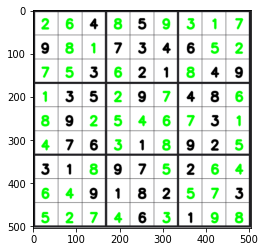

In [30]:
predicted_numbers, final = origin_final(image_sudoku)
origin, final, somme = test(predicted_numbers, final)
plt.imshow(displaySolution(blank_sudoku, origin, final))